In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import sklearn
import PIL
import torch
import torchvision
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

### Зачем
- Посмотрим, как проводится операция свертки;
- Посмотрим, как работает pooling;
- Попробуем собрать сверточную нейронную сеть на PyTorch

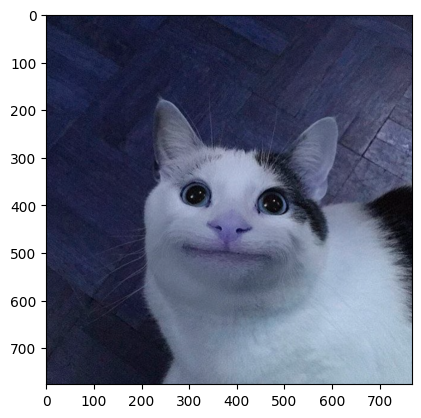

In [3]:
image = cv2.imread('./image.png')
plt.imshow(image);

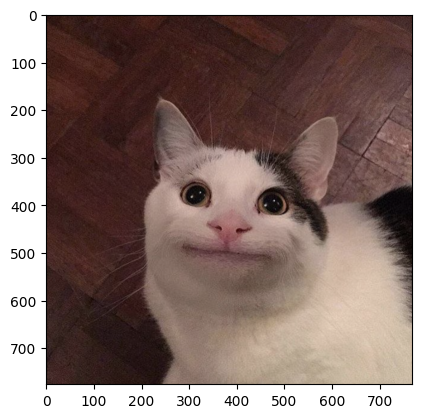

In [4]:
image_ex = image[...,::-1]
plt.imshow(image_ex)

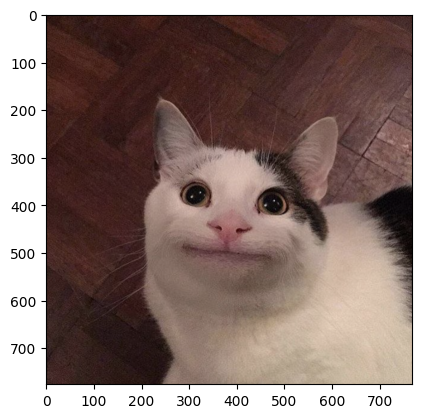

In [5]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb);

Посмотрим на каналы изображения отдельно

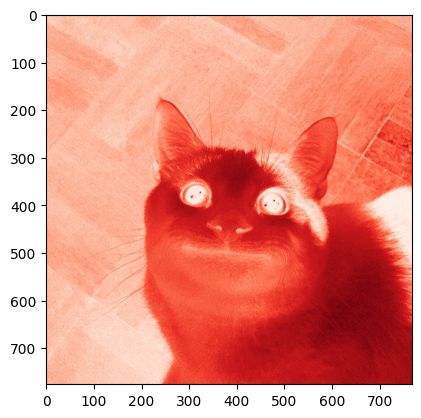

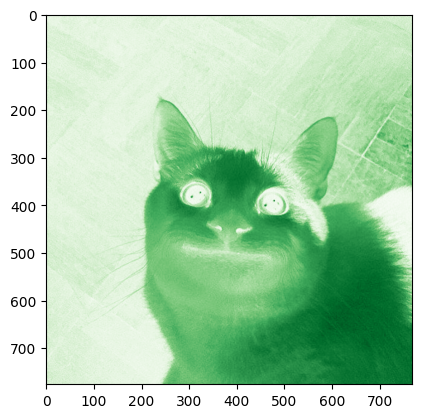

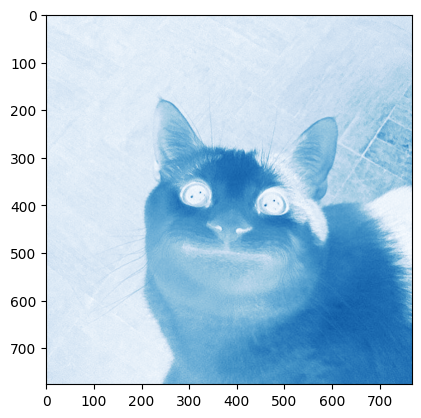

In [6]:
img_mat = np.array(image_rgb)
plt.imshow(img_mat[:, :, 0], cmap=cm.Reds)
plt.show()

img_mat = np.array(image_rgb)
plt.imshow(img_mat[:, :, 1], cmap=cm.Greens)
plt.show()

img_mat = np.array(image_rgb)
plt.imshow(img_mat[:, :, 2], cmap=cm.Blues)
plt.show()

# Операция свертки

- Количество входных каналов `in_channels`
- Количество выходных каналов `out_channels`
- Размер ядра `kernel_size`
- Шаг `stride`
- Паддинг `padding`
- Режим паддинга `padding_mode` (`'zeros'`, `'reflect'`, ...)


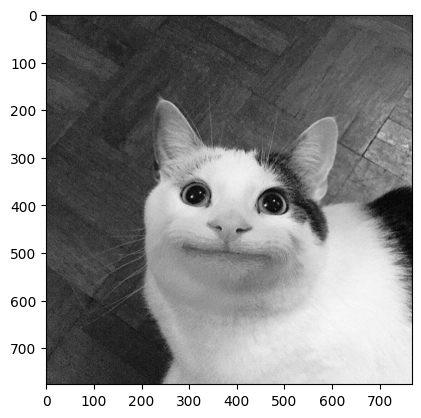

In [7]:
bw_image = cv2.imread('./image.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(bw_image, cmap=plt.cm.Greys_r)

In [8]:
# !pip3 install scipy

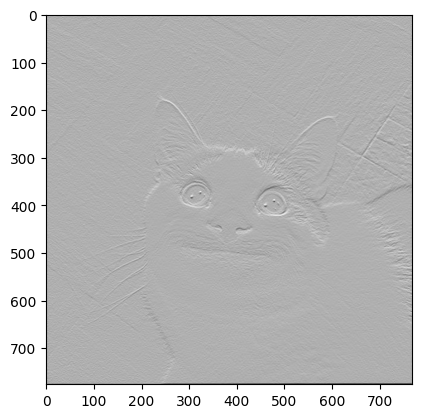

In [9]:
from scipy.signal import convolve2d

G_y = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
])

res_y = convolve2d(bw_image, G_y, "same")
plt.imshow(res_y, cmap=plt.cm.Greys_r)

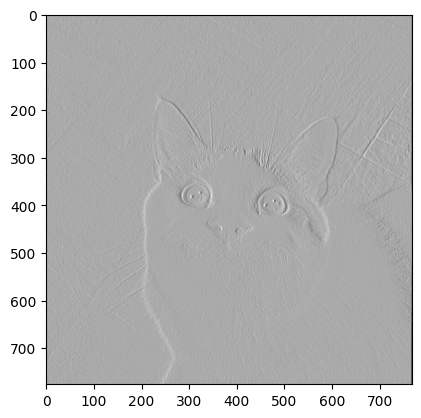

In [10]:
G_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

res_x = convolve2d(bw_image, G_y.T, "same")
plt.imshow(res_x, cmap=plt.cm.Greys_r)

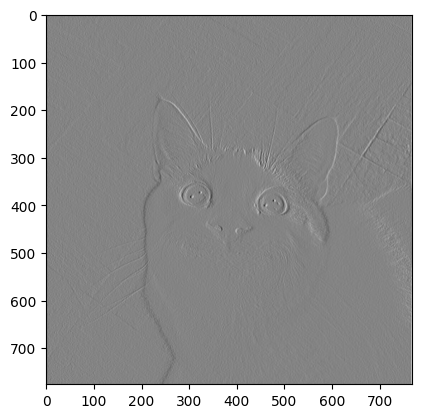

In [11]:
res_x = convolve2d(bw_image, G_x, "same")
plt.imshow(res_x, cmap=plt.cm.Greys_r)

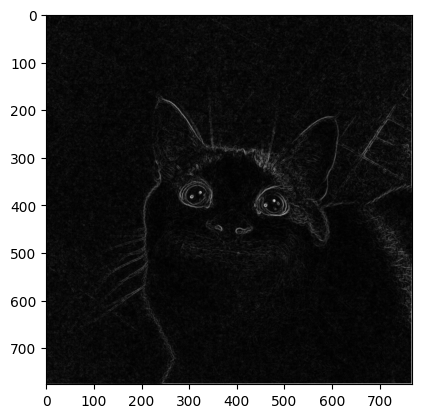

In [12]:
res_sobel = (res_x**2 + res_y**2)**0.5
plt.imshow(res_sobel, cmap=plt.cm.Greys_r)

# Пулинг

In [13]:
import numpy as np

conv_output = np.array([
    [10, 12,  8,  7],
    [ 4, 11,  5,  9],
    [18, 13,  7,  7],
    [ 3, 15,  2,  2]
])
conv_output

array([[10, 12,  8,  7],
       [ 4, 11,  5,  9],
       [18, 13,  7,  7],
       [ 3, 15,  2,  2]])

Сначала попробуем со `stride=2`

In [14]:
pool_size = 2
stride = 2

def get_pools(img=conv_output, pool_size=2, stride=2):

    pools = []
    for i in np.arange(conv_output.shape[0], step=stride):
        for j in np.arange(conv_output.shape[0], step=stride):
            mat = conv_output[i:i+pool_size, j:j+pool_size]
            pools.append(mat)
    pools = np.array(pools)
    return pools

pools = get_pools()
pools

array([[[10, 12],
        [ 4, 11]],

       [[ 8,  7],
        [ 5,  9]],

       [[18, 13],
        [ 3, 15]],

       [[ 7,  7],
        [ 2,  2]]])

In [15]:
def max_pooling(pools: np.array) -> np.array:

    num_pools = pools.shape[0]

    # Размер матрицы после пулинга
    tgt_shape = (int(np.sqrt(num_pools)), int(np.sqrt(num_pools)))

    # Здесь будем хранить максимумы с каждого из пулов
    pooled = []
    for pool in pools:
        pooled.append(np.max(pool))

    return np.array(pooled).reshape(tgt_shape)

In [16]:
max_pooling(pools=pools)

array([[12,  9],
       [18,  7]])

# Сверточная нейронная сеть

In [17]:
import torch
import torch.nn.functional as F
import torchvision
import os
from torch import nn
from tqdm import tqdm

In [18]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]
)

In [19]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [20]:
seed_everything(42)

mnist_train = torchvision.datasets.MNIST(
    './mnist/',
    train=True,
    download=True,
    transform=transform
)

mnist_val = torchvision.datasets.MNIST(
    './mnist/',
    train=False,
    download=True,
    transform=transform
)

train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=64, shuffle=True)

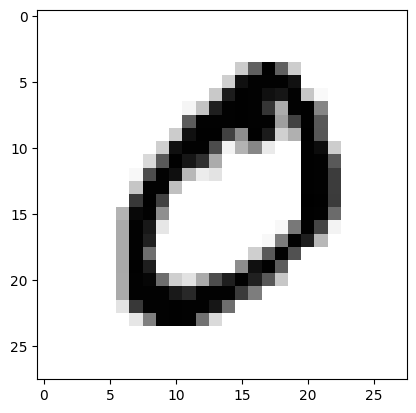

In [21]:
plt.imshow(mnist_train[1][0].squeeze(0).numpy().reshape([28, 28]), cmap=plt.cm.gray_r)

In [22]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [23]:
def train(model, optimizer, n_epochs=5):
    for epoch in range(n_epochs):

        # обучение
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # валидация
        if epoch % 2 == 0:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    loss = F.cross_entropy(y_pred, y_val)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())

            print(f'Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}')

In [24]:
train(model, optimizer)

100%|██████████| 157/157 [00:02<00:00, 63.33it/s]


Epoch: 0, loss: 0.3202982246875763, accuracy: 0.9098


100%|██████████| 157/157 [00:02<00:00, 74.15it/s]


Epoch: 2, loss: 0.23288892209529877, accuracy: 0.9315


100%|██████████| 157/157 [00:01<00:00, 79.15it/s]

Epoch: 4, loss: 0.18694597482681274, accuracy: 0.9461


In [25]:
0.9462

0.9462

In [26]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),  # grayscale
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   # сократим изображение в 4 раза по каждой из сторон
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [27]:
train(model, optimizer)

100%|██████████| 157/157 [00:02<00:00, 63.53it/s]


Epoch: 0, loss: 0.2660142779350281, accuracy: 0.9249


100%|██████████| 157/157 [00:03<00:00, 47.74it/s]


Epoch: 2, loss: 0.12705570459365845, accuracy: 0.9624


100%|██████████| 157/157 [00:02<00:00, 59.40it/s]

Epoch: 4, loss: 0.08610931038856506, accuracy: 0.9746


In [28]:
0.9747

0.9747

# Домашнее задание

Обучите сверточную нейронную сеть на датасете MNIST, взяв любой другой оптимизатор (кроме SGD) и любую другую функцию ошибки (кроме cross-entropy loss). Попробуйте поварьировать параметры: кол-во ядер, `kernel_size` и побить текущий бейзлайн в `0.9747`. Выведите количество обучаемых параметров.    
Какого качества удалось достичь? Попробуйте залоггировать Ваши результаты - построить графики того, как менялись метрики качества (accuracy, loss) с течением эпох, включить логгирование, сравнить результаты между собой при разных параметрах.

Любые дополнительные улучшения (как по методам, так и по коду пайплайна) приветствуются!

*Цель:* выработать навык обучения нейронных сетей (в частности сверточных) на основе средств PyTorch, начиная от загрузки датасетами и заканчивая выводами результатов, их логгированием, сравнением и анализом.

In [29]:
loss_graphic = []
accuracy_graphic = []

Для экспериментов с моделью я попробую взять не совсем подходящий для классификации лосс, чтобы узнать что получится. В качестве оптимизатора выберу Adam, как пишут умные (как мне кажется) люди на хабре, хороший вариант для начала.

In [30]:
def train(model, optimizer, n_epochs=5):
    for epoch in range(n_epochs):

        # обучение
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            y_train_one_hot = F.one_hot(y_train, num_classes=10).float()
            loss = F.mse_loss(y_pred, y_train_one_hot)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # валидация
        if epoch % 2 == 0:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    y_val_one_hot = F.one_hot(y_val, num_classes=10).float()
                    loss = F.mse_loss(y_pred, y_val_one_hot)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())

            print(f'Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}')

In [31]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.Softmax(dim=1)
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [32]:
train(model, optimizer)

100%|██████████| 157/157 [00:03<00:00, 45.06it/s]


Epoch: 0, loss: 0.004492523614317179, accuracy: 0.9711


100%|██████████| 157/157 [00:02<00:00, 63.78it/s]


Epoch: 2, loss: 0.009560644626617432, accuracy: 0.9507


100%|██████████| 157/157 [00:02<00:00, 52.48it/s]

Epoch: 4, loss: 0.008959735743701458, accuracy: 0.9547


По падающему лоссу можно сделать вывод, что эксперименты с лоссами не предназначенными для классификации не самая хорошая идея. Мы в итоге просто размазываем вероятности по классам, пытаясь минимизировать средний квадрат ошибок

In [33]:
loss_graphic.append(0.0126)
accuracy_graphic.append(0.9364)

In [34]:
def train(model, optimizer, n_epochs=5):
    for epoch in range(n_epochs):

        # обучение
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = F.nll_loss(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # валидация
        if epoch % 2 == 0:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    loss = F.nll_loss(y_pred, y_val)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())

            print(f'Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}')

In [35]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [36]:
train(model, optimizer)

100%|██████████| 157/157 [00:02<00:00, 55.31it/s]


Epoch: 0, loss: 0.06557730585336685, accuracy: 0.9804


100%|██████████| 157/157 [00:02<00:00, 73.02it/s]


Epoch: 2, loss: 0.06860855966806412, accuracy: 0.9786


100%|██████████| 157/157 [00:02<00:00, 73.61it/s]

Epoch: 4, loss: 0.07983671873807907, accuracy: 0.9773


Получилось пробить требуемое значение accuracy, NLLLoss подходит для многоклассовой классификации куда лучше, далее попытаюсь поиграть значениями слоев и их количеством

In [37]:
loss_graphic.append(0.0727)
accuracy_graphic.append(0.9799)

In [38]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Flatten(),
    nn.Linear(6*6*20, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [39]:
train(model, optimizer)

100%|██████████| 157/157 [00:02<00:00, 69.05it/s]


Epoch: 0, loss: 0.07436536252498627, accuracy: 0.9754


100%|██████████| 157/157 [00:02<00:00, 60.97it/s]


Epoch: 2, loss: 0.06721485406160355, accuracy: 0.98


100%|██████████| 157/157 [00:02<00:00, 63.23it/s]

Epoch: 4, loss: 0.06459375470876694, accuracy: 0.9836


Добавление дополнительных фильтров на первый слой не дало никаких преимуществ модели, похоже, что когда мы используем 10 фильтров, то уже вытягиваем из изображений все возможные структуры, поэтому с ростом количества фильтров я не получу никакого бонуса в accuracy. Попробую изменить размер ядра

In [40]:
loss_graphic.append(0.7811)
accuracy_graphic.append(0.9798)

In [41]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(13*13*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [42]:
train(model, optimizer)

100%|██████████| 157/157 [00:02<00:00, 72.49it/s]


Epoch: 0, loss: 0.0653858557343483, accuracy: 0.9779


100%|██████████| 157/157 [00:13<00:00, 11.33it/s]


Epoch: 2, loss: 0.09242221713066101, accuracy: 0.9761


100%|██████████| 157/157 [00:03<00:00, 51.60it/s]

Epoch: 4, loss: 0.08749961853027344, accuracy: 0.9799


Модель опять показала ухудшения, хотя более мелкий фильтр должен позволить модели детальнее изучить картинку, похоже это ухудшает способность модели улавливать более общие черты. Вполне возможно, что сама модель слишком простая, далее попробую усложнить модель, добавив дополнительный слой свертки

In [43]:
loss_graphic.append(0.1015)
accuracy_graphic.append(0.9778)

In [46]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3),
    nn.ReLU(),
    nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(12*12*20, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [47]:
train(model, optimizer)

100%|██████████| 157/157 [00:05<00:00, 27.57it/s]


Epoch: 0, loss: 0.07786443084478378, accuracy: 0.9763


100%|██████████| 157/157 [00:03<00:00, 40.75it/s]


Epoch: 2, loss: 0.07732969522476196, accuracy: 0.9792


100%|██████████| 157/157 [00:03<00:00, 51.76it/s]

Epoch: 4, loss: 0.06925070285797119, accuracy: 0.9817


In [48]:
loss_graphic.append(0.0693)
accuracy_graphic.append(0.9817)

А теперь попробуем вернуть размер ядра равным 5 и проверим, что из этого получится

In [49]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),
    nn.ReLU(),
    nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(10*10*20, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [50]:
train(model, optimizer)

100%|██████████| 157/157 [00:03<00:00, 42.34it/s]


Epoch: 0, loss: 2.3023569583892822, accuracy: 0.1028


100%|██████████| 157/157 [00:03<00:00, 45.41it/s]


Epoch: 2, loss: 2.302553653717041, accuracy: 0.1028


100%|██████████| 157/157 [00:10<00:00, 15.47it/s]

Epoch: 4, loss: 2.3020007610321045, accuracy: 0.1135


In [51]:
loss_graphic.append(2.302)
accuracy_graphic.append(0.1135)

Результат мягко говоря ужасный, похоже, что проходясь большими шагами по картинке 2 раза, мы теряемся и не находим ничего. Интересно, если изменить одно из двух ядер на 3, то результат будет лучше, когда у первой свертки ядро равно 3 или у второй. Проверим!

In [ ]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3),
    nn.ReLU(),
    nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(11*11*20, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [54]:
train(model, optimizer)

100%|██████████| 157/157 [00:03<00:00, 44.87it/s]


Epoch: 0, loss: 2.3017919063568115, accuracy: 0.1135


100%|██████████| 157/157 [00:02<00:00, 64.41it/s]


Epoch: 2, loss: 2.301511287689209, accuracy: 0.1135


100%|██████████| 157/157 [00:02<00:00, 60.85it/s]

Epoch: 4, loss: 2.301377296447754, accuracy: 0.1135


In [55]:
loss_graphic.append(2.3014)
accuracy_graphic.append(0.1135)

Не очень удивительно, что когда мы сначала идем мелкими шагами, а позже большими, то результат не будет впечатляющим.  Предположительно в зеркальной ситуации все должно быть радужнее

In [56]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),
    nn.ReLU(),
    nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(11*11*20, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [57]:
train(model, optimizer)

100%|██████████| 157/157 [00:02<00:00, 71.40it/s]


Epoch: 0, loss: 0.08382871747016907, accuracy: 0.9752


100%|██████████| 157/157 [00:02<00:00, 70.01it/s]


Epoch: 2, loss: 0.07866358011960983, accuracy: 0.9777


100%|██████████| 157/157 [00:02<00:00, 71.38it/s]

Epoch: 4, loss: 0.0927082747220993, accuracy: 0.9786


In [58]:
loss_graphic.append(0.0927)
accuracy_graphic.append(0.9786)

Успех! Результат стал заметно лучше, хотя мой лучший все еще не перебит. Далее построю график моих попыток и подведем итог.

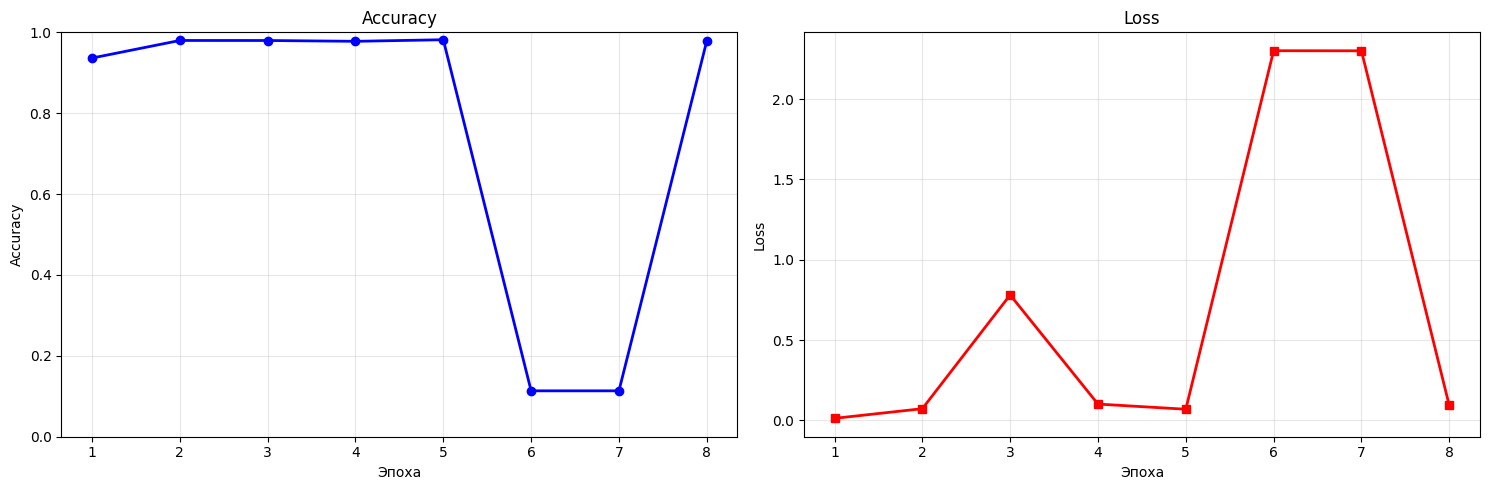

In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(range(1, len(accuracy_graphic) + 1), accuracy_graphic, marker='o', color='blue', linewidth=2)
ax1.set_xlabel('Эпоха')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)

ax2.plot(range(1, len(loss_graphic) + 1), loss_graphic, marker='s', color='red', linewidth=2)
ax2.set_xlabel('Эпоха')
ax2.set_ylabel('Loss')
ax2.set_title('Loss')
ax2.grid(True, alpha=0.3)

plt.tight_layout()

Выглядят графики не впечатляюще, однако вывод сделать не сложно, худшие результаты были при необдуманных проходах крупными шагами по изображениям, лучшие же при проходе мелкими